In [1]:
from dreye.core import Spectrum, SpectrumMeasurement, \
    MeasuredSpectrum, convert_measurement, CalibrationSpectrum, \
    AbstractSpectrum, Signal, Domain
from dreye.core import LogPhotoreceptor, \
    RelativeOpsinSensitivity, Spectrum, Domain
from dreye.stimuli.tempochromatic.noise import PRWhiteNoiseStimulus, \
    PRBrownNoiseStimulus, TransformWhiteNoiseStimulus, \
    TransformBrownNoiseStimulus, IlluminantWhiteNoiseStimulus, \
    IlluminantBgWhiteNoiseStimulus
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from dreye.core import create_gaussian_spectrum
np.random.seed(10)

In [2]:
wl = np.arange(300, 600)
s = norm.pdf(wl, 450, 10)
s /= np.sum(s)
noise = 0.01
s_noise = s + np.random.normal(0, noise, size=s.shape)
ops = norm.pdf(wl, 433, 40)

In [3]:
opsin2 = RelativeOpsinSensitivity(
    norm.pdf(wl[:,None], asarray([[330, 450, 560]]), 40),
    domain=wl, 
)

/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


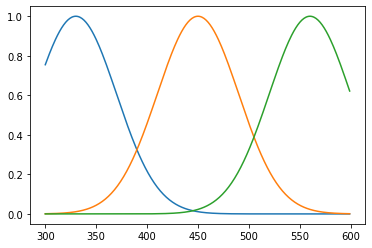

In [4]:
plt.plot(wl, opsin2)

In [5]:
pr = LogPhotoreceptor(opsin2)
cal = CalibrationSpectrum(
    np.ones(wl.shape), 
    wl, 
    area=1
)

In [6]:
pr.sensitivity.labels

array([0, 1, 2])

In [7]:
for idx, led in enumerate([300, 360, 400, 500]):
    
    s2 = norm.pdf(wl, led, 20)
    if idx % 2:
        mess = convert_measurement(
            AbstractSpectrum(
                10 * s2 + np.random.normal(0, noise, size=s.shape), 
                wl
            ), cal, 1
        ).uE
    else:
        mess = convert_measurement(
            AbstractSpectrum(
                s2 + np.random.normal(0, noise, size=s.shape), 
                wl
            ), cal, 1
        ).uE

    for i in np.arange(2, 10)[::asarray([1, -1])[idx % 2]]:
        m = convert_measurement(
            AbstractSpectrum(
                i * s2 + np.random.normal(0, noise, size=s.shape), 
                wl
            ),
            cal, 1
        ).irradiance

        mess = mess.concat(
            m, 
        )

    ms = MeasuredSpectrum(
        mess,
        labels=Domain(np.arange(1, 10), units='volts'), 
        smoothing_window=25, 
    ).to_spectrum_measurement(
        name=f'LED{led}',
        zero_boundary=asarray([0, 10])[idx % 2], 
        max_boundary=asarray([10, 0])[idx % 2]
        #zero_is_lower=not bool(idx%2)
    )
    
        
    if idx == 0:
        mss = ms
    else:
        mss = mss.concat(ms)

In [8]:
ms.max_boundary, ms.zero_boundary

(array([0]), array([10]))

In [9]:
ms.labels._zero_is_lower

array([False])

In [10]:
mss.zero_is_lower

array([ True, False,  True, False])

In [11]:
mss.save('test_spms.json')

In [12]:
mss2 = mss.load('test_spms.json')

In [13]:
mss2.label_names

['LED300', 'LED360', 'LED400', 'LED500']

In [14]:
mss.max_boundary

array([10,  0, 10,  0])

In [15]:
mss.zero_is_lower

array([ True, False,  True, False])

In [16]:
mss.label_names

['LED300', 'LED360', 'LED400', 'LED500']

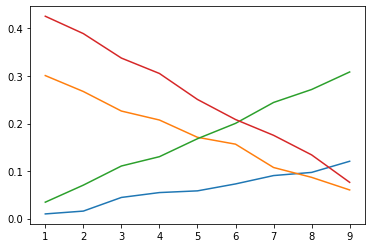

In [17]:
plt.plot(mss.domain, mss)

/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


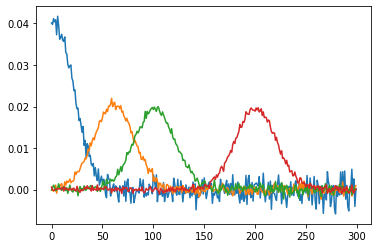

In [19]:
plt.plot(mss.normalized_spectrum)

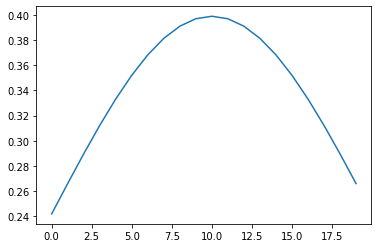

In [25]:
from scipy.stats import norm
plt.plot(norm.pdf(np.arange(-1, 1, 0.1)))

In [16]:
gaussians = create_gaussian_spectrum(
    wl, 
    [340, 440, 540], 
    intensity=1, 
    background=np.ones(wl.shape)/10000, 
    add_background=True, 
    cdf=False,
    filter=True,
)

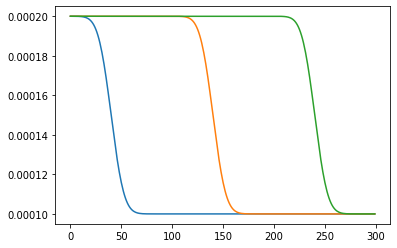

In [17]:
plt.plot(gaussians)

In [18]:
background = Spectrum(gaussians[:, 2]/1, wl)

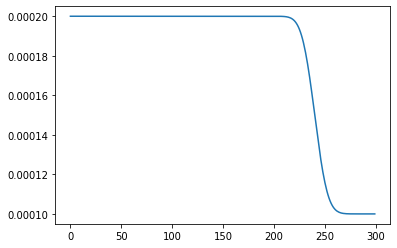

In [19]:
plt.plot(background)

In [20]:
pr.get_A(
    mss, 
    background, 
    False
)

array([[61.96289544, 46.04901259, 16.2434585 ,  0.55284791],
       [-0.76885589,  5.92541969, 24.81343184, 23.3643037 ],
       [-3.07486843, -0.5115111 ,  0.32660423, 32.28691924]])

In [21]:
pr.get_qs(
    mss, 
    gaussians, 
    background=background, 
    units=False, 
    return_A=False
)

array([[0.73869235, 0.50551151, 0.72688656],
       [0.99753267, 0.70718684, 0.72845714],
       [1.        , 1.        , 1.        ]])

In [22]:
output, res = pr.fit(
    mss, 
    gaussians, 
    background=background, 
    return_res=True
)

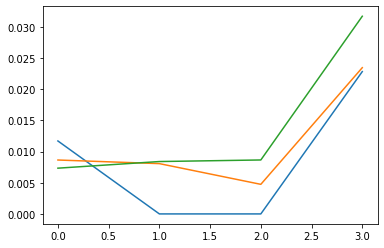

In [23]:
plt.plot(output.T)

In [24]:
wn = PRWhiteNoiseStimulus(
    pr, 
    mss, 
    background,
    rate=60, 
    n_channels=3, 
    mean=0, 
    var=asarray([0.01,0.02,0.1]), 
    minimum=-100, 
    maximum=100, 
    iterations=2, 
    start_delay=1, 
    end_dur=1, 
    pause_dur=1, 
    seed=10, 
    filter_style='window', 
    filter_function='exponential', 
    filter_along_axis=0, 
    filter_kwargs={'M':5, 'tau':2.5}
)

In [25]:
wn.create()

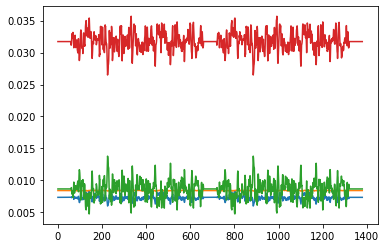

In [26]:
plt.plot(wn.metadata['channel_weights'])

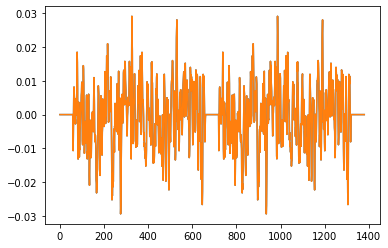

In [27]:
plt.plot(wn.metadata['target_signal'][:, 1])
plt.plot(wn.signal[:, 1])

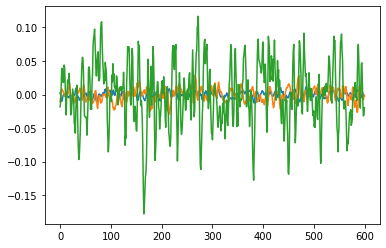

In [28]:
plt.plot(wn.metadata['random_signal'])

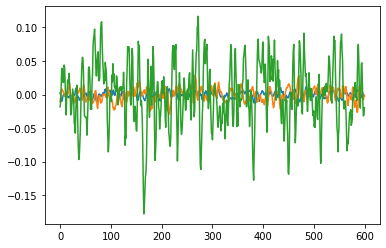

In [29]:
plt.plot(wn.metadata['random_signal'])

In [30]:
wn.transform()

/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [31]:
wn.stimulus

array([[0.56980969, 9.        , 0.2504481 , 9.        ],
       [0.56980969, 9.        , 0.2504481 , 9.        ],
       [0.56980969, 9.        , 0.2504481 , 9.        ],
       ...,
       [0.56980969, 9.        , 0.2504481 , 9.        ],
       [0.56980969, 9.        , 0.2504481 , 9.        ],
       [0.56980969, 9.        , 0.2504481 , 9.        ]])

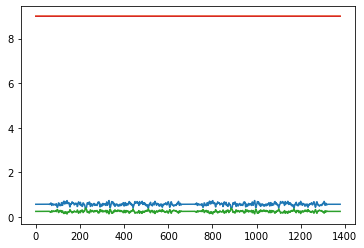

In [35]:
plt.plot(wn.stimulus)

In [33]:
wn = TransformWhiteNoiseStimulus(
    np.ones(3)[:, None], 
    pr, 
    mss, 
    background,
    rate=60, 
    n_channels=1, 
    mean=0, 
    var=0.1, 
    minimum=-100, 
    maximum=100, 
    iterations=2, 
    start_delay=2, 
    end_dur=2, 
    pause_dur=2, 
    seed=10, 
    filter_style='window', 
    filter_function='exponential', 
    filter_along_axis=0, 
    filter_kwargs={'M':61, 'tau':20}
)

In [34]:
wn.create()

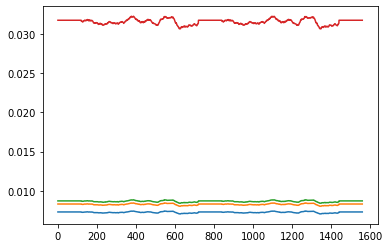

In [35]:
plt.plot(wn.metadata['channel_weights'])

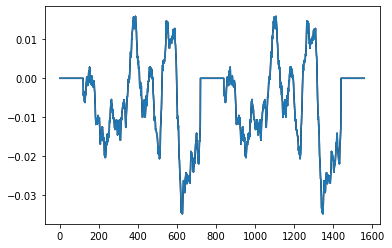

In [36]:
plt.plot(wn.metadata['target_signal'], color='black')
plt.plot(wn.signal)

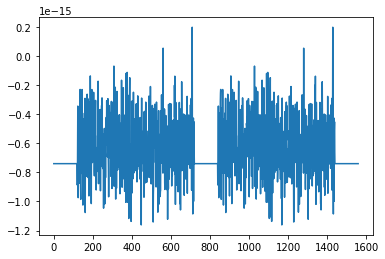

In [37]:
plt.plot(wn.metadata['res_signal'])

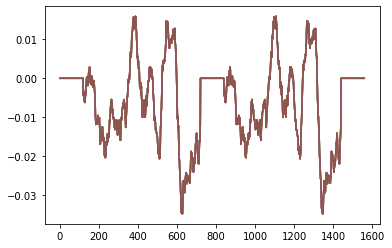

In [38]:
plt.plot(wn.metadata['lineartransform_target_signal'])
plt.plot(wn.metadata['lineartransform_signal'])

/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


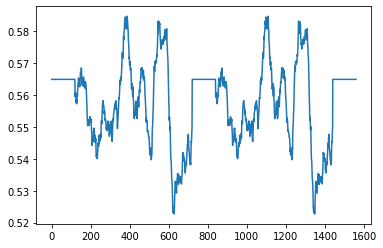

In [39]:
plt.plot(wn.stimulus[:, 0])

In [40]:
gaussians2 = create_gaussian_spectrum(
    wl, 
    [500, 300], 
    intensity=0.5, 
    background=np.ones(wl.shape), 
    add_background=True, 
    cdf=None,
    filter=True,
)

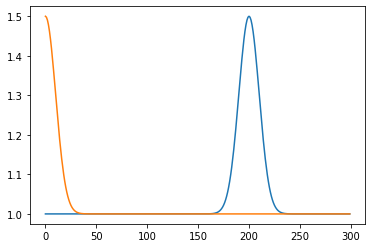

In [41]:
plt.plot(gaussians2)

In [42]:
wn = IlluminantWhiteNoiseStimulus(
    gaussians2/500, 
    pr, 
    mss, 
    background,
    rate=60, 
    n_channels=2, 
    mean=0, 
    var=[0.1, 0.5], 
    minimum=-100, 
    maximum=100, 
    iterations=2, 
    start_delay=2, 
    end_dur=2, 
    pause_dur=2, 
    seed=10, 
    filter_style='window', 
    filter_function='exponential', 
    filter_along_axis=0, 
    filter_kwargs={'M':61, 'tau':20}
)

In [43]:
wn.linear_transform

array([[2.30261711, 2.36916499],
       [2.36634081, 2.30995862],
       [2.72588301, 2.67674736]])

In [44]:
wn.create()

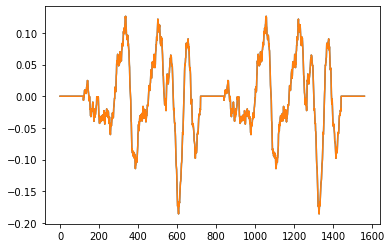

In [45]:
plt.plot(wn.metadata['target_signal'][:, 1])
plt.plot(wn.signal[:, 1])

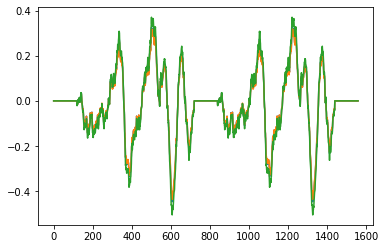

In [46]:
plt.plot(wn.metadata['lineartransform_target_signal'])

In [47]:
wn = IlluminantBgWhiteNoiseStimulus(
    gaussians2, 
    pr, 
    mss, 
    background,
    rate=60, 
    n_channels=2, 
    mean=0, 
    var=[0.1, 0.5], 
    minimum=None, 
    maximum=None, 
    iterations=2, 
    start_delay=2, 
    end_dur=2, 
    pause_dur=2, 
    seed=10, 
    filter_style='window', 
    filter_function='exponential', 
    filter_along_axis=0, 
    filter_kwargs={'M':61, 'tau':20}, 
    bg_func=lambda x, bg: (x * bg) + bg
)

In [48]:
wn.create()

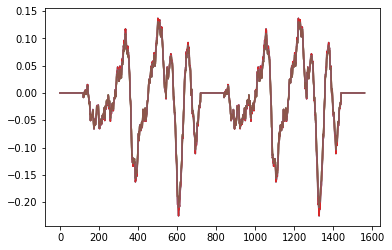

In [49]:
plt.plot(wn.signal)
plt.plot(wn.metadata['target_signal'])

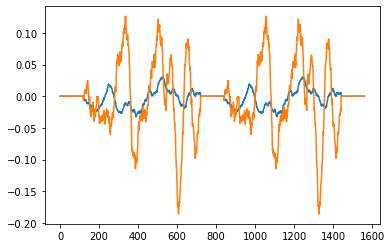

In [50]:
plt.plot(wn.metadata['original_signal'])

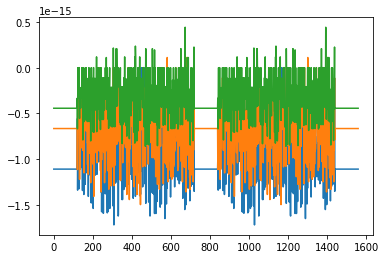

In [51]:
plt.plot(wn.metadata['res_signal'])

In [52]:
wn.events

,delay,dur,iter,name,0,1,pr0,pr1,pr2
0,2.0,10.0,0,IlluminantBgWhiteNoiseStimulus,"[-0.0014492872355317784, -0.001699283586882110...","[-0.006515941643004829, -0.002780006182778814,...","[-0.008449469638210343, -0.004681678930667354,...","[-0.008083516904344243, -0.004589644655309594,...","[-0.008103852878452462, -0.0046140577299139994..."
1,14.0,10.0,1,IlluminantBgWhiteNoiseStimulus,"[-0.0014492872355317784, -0.001699283586882110...","[-0.006515941643004829, -0.002780006182778814,...","[-0.008449469638210343, -0.004681678930667354,...","[-0.008083516904344243, -0.004589644655309594,...","[-0.008103852878452462, -0.0046140577299139994..."


In [53]:
from dreye.stimuli.tempochromatic.step import (
    PRStepStimulus, TransformStepStimulus
)

In [54]:
step = PRStepStimulus(
    photoreceptor=pr, 
    spectrum_measurement=mss, 
    background=background,
    values={
        'rh3': [0.2, 0.4, 0.3], 
        'rh4': [0.4, 0.2, 0.1], 
        'rh5': [0.2, 0.1, 0.3]
    }, 
    separate_channels=True, 
    repetitions=3, 
    iterations=3, 
    rate=60., 
    durations=[3, 3], 
    pause_durations=[2, 3], 
    randomize=True, 
    start_delay=1, 
    end_dur=1
)

In [55]:
step.create()

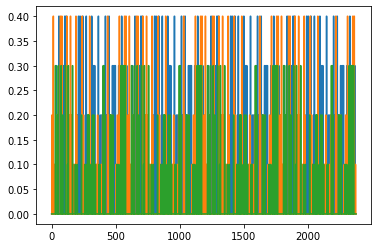

In [56]:
plt.plot(step.timestamps, step.signal)

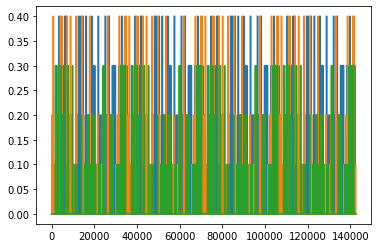

In [57]:
plt.plot(step.metadata['target_signal'])

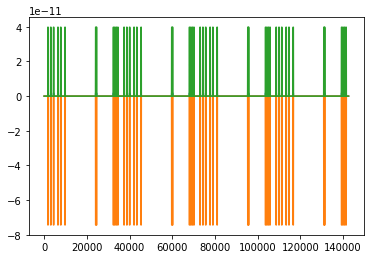

In [58]:
plt.plot(step.metadata['res_signal'])

In [59]:
step.events

,rh3,rh4,rh5,dur,pause,repeat,iter,delay,name,0,1,2
0,0.0,0.2,0.0,3.0,3.0,4,0,1.0,PRStepStimulus,1.110223e-15,2.000000e-01,2.220446e-16
1,0.2,0.0,0.0,3.0,2.0,0,0,6.0,PRStepStimulus,2.000000e-01,4.440892e-16,2.220446e-16
2,0.0,0.4,0.0,3.0,2.0,3,0,11.0,PRStepStimulus,8.881784e-16,4.000000e-01,-1.110223e-16
3,0.0,0.1,0.0,3.0,2.0,5,0,16.0,PRStepStimulus,4.440892e-16,1.000000e-01,2.220446e-16
4,0.0,0.1,0.0,3.0,3.0,5,0,22.0,PRStepStimulus,4.440892e-16,1.000000e-01,2.220446e-16
...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.0,0.4,0.0,3.0,3.0,3,2,2350.0,PRStepStimulus,8.881784e-16,4.000000e-01,-1.110223e-16
428,0.0,0.0,0.3,3.0,3.0,8,2,2356.0,PRStepStimulus,-1.740830e-12,7.432277e-11,3.000000e-01
429,0.0,0.4,0.0,3.0,2.0,3,2,2361.0,PRStepStimulus,8.881784e-16,4.000000e-01,-1.110223e-16
430,0.3,0.0,0.0,3.0,2.0,2,2,2366.0,PRStepStimulus,3.000000e-01,6.661338e-16,2.220446e-16


In [60]:
step.values

,rh3,rh4,rh5
0,0.2,0.0,0.0
1,0.4,0.0,0.0
2,0.3,0.0,0.0
3,0.0,0.4,0.0
4,0.0,0.2,0.0
5,0.0,0.1,0.0
6,0.0,0.0,0.2
7,0.0,0.0,0.1
8,0.0,0.0,0.3


In [61]:
step = TransformStepStimulus(
    linear_transform=asarray([
        [0.5, -0.5, 0.5], [1, 1, -2]
    ]).T,
    linear_transform_labels=['a', 'b'],
    photoreceptor=pr, 
    spectrum_measurement=mss, 
    background=background,
    values={
        'rh3': [0.2, 0.4, 0.3], 
        'rh4': [0.4, 0.2, 0.1], 
    }, 
    separate_channels=True, 
    repetitions=1, 
    iterations=1, 
    rate=60., 
    durations=[3, 3], 
    pause_durations=[2, 3], 
    randomize=True, 
    start_delay=1, 
    end_dur=1
)

In [62]:
step.create()

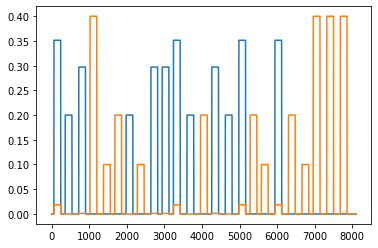

In [63]:
plt.plot(step.signal)

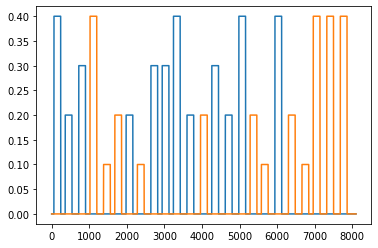

In [64]:
plt.plot(step.metadata['target_signal'])

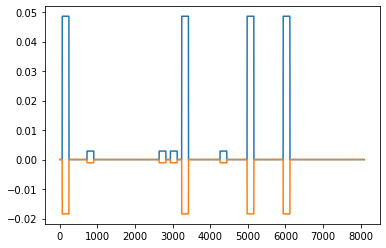

In [65]:
plt.plot(step.metadata['res_signal'])

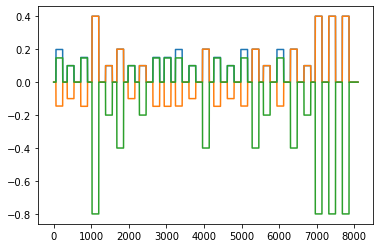

In [66]:
plt.plot(step.metadata['lineartransform_signal'])

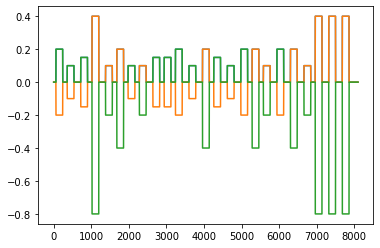

In [67]:
plt.plot(step.metadata['lineartransform_target_signal'])

In [68]:
step.transform()

/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


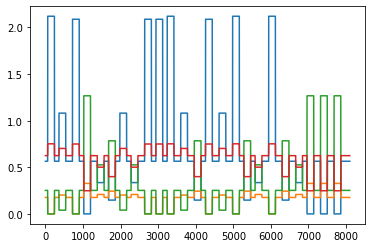

In [69]:
plt.plot(step.stimulus)

In [70]:
step.events

,rh3,rh4,dur,pause,repeat,iter,delay,name,0,1,...,a,b,LED300,LED360,LED400,LED500,stiminLED300,stiminLED360,stiminLED400,stiminLED500
0,0.4,0.0,3.0,2.0,1,0,1.0,TransformStepStimulus,0.198190,-0.145118,...,3.514082e-01,1.843593e-02,2.120091,0.000000,1.129601e-09,0.751806,0.019278581819134943 microspectral_E_Q * nanom...,2.0103790057497892e-10 microspectral_E_Q * nan...,3.904411154836745e-11 microspectral_E_Q * nano...,0.03771853207178328 microspectral_E_Q * nanometer
1,0.2,0.0,3.0,2.0,0,0,6.0,TransformStepStimulus,0.100000,-0.100000,...,2.000000e-01,3.811639e-16,1.080948,0.202531,4.045610e-02,0.702227,0.010375279936509881 microspectral_E_Q * nanom...,0.00901322691218262 microspectral_E_Q * nanometer,0.001398345839431797 microspectral_E_Q * nanom...,0.0353836400160208 microspectral_E_Q * nanometer
2,0.3,0.0,3.0,3.0,2,0,12.0,TransformStepStimulus,0.149898,-0.146752,...,2.971280e-01,1.094275e-03,2.087804,0.000000,1.974457e-08,0.749872,0.018351910067571826 microspectral_E_Q * nanom...,1.0001311780941161e-09 microspectral_E_Q * nan...,6.824616352783722e-10 microspectral_E_Q * nano...,0.03762746181689992 microspectral_E_Q * nanometer
3,0.0,0.4,3.0,2.0,3,0,17.0,TransformStepStimulus,0.400000,0.400000,...,5.619426e-16,4.000000e-01,0.000000,0.327024,1.266943e+00,0.248386,0.0031632387001899608 microspectral_E_Q * nano...,0.01233016118786694 microspectral_E_Q * nanometer,0.04413753356151029 microspectral_E_Q * nanometer,0.014010411815589308 microspectral_E_Q * nanom...
4,0.0,0.1,3.0,3.0,5,0,23.0,TransformStepStimulus,0.100000,0.100000,...,6.560928e-16,1.000000e-01,0.336000,0.208600,5.262745e-01,0.501316,0.005952433807413738 microspectral_E_Q * nanom...,0.009174920928278972 microspectral_E_Q * nanom...,0.018190425362593025 microspectral_E_Q * nanom...,0.025921922576581637 microspectral_E_Q * nanom...
5,0.0,0.2,3.0,2.0,4,0,28.0,TransformStepStimulus,0.200000,0.200000,...,2.098710e-16,2.000000e-01,0.148028,0.244082,7.842166e-01,0.399901,0.004836421480222537 microspectral_E_Q * nanom...,0.010120300821036071 microspectral_E_Q * nanom...,0.0271060701185861 microspectral_E_Q * nanometer,0.021145894331862678 microspectral_E_Q * nanom...
6,0.2,0.0,3.0,2.0,0,0,33.0,TransformStepStimulus,0.100000,-0.100000,...,2.000000e-01,3.811639e-16,1.080948,0.202531,4.045610e-02,0.702227,0.010375279936509881 microspectral_E_Q * nanom...,0.00901322691218262 microspectral_E_Q * nanometer,0.001398345839431797 microspectral_E_Q * nanom...,0.0353836400160208 microspectral_E_Q * nanometer
7,0.0,0.1,3.0,2.0,5,0,38.0,TransformStepStimulus,0.100000,0.100000,...,6.560928e-16,1.000000e-01,0.336000,0.208600,5.262745e-01,0.501316,0.005952433807413738 microspectral_E_Q * nanom...,0.009174920928278972 microspectral_E_Q * nanom...,0.018190425362593025 microspectral_E_Q * nanom...,0.025921922576581637 microspectral_E_Q * nanom...
8,0.3,0.0,3.0,3.0,2,0,44.0,TransformStepStimulus,0.149898,-0.146752,...,2.971280e-01,1.094275e-03,2.087804,0.000000,1.974457e-08,0.749872,0.018351910067571826 microspectral_E_Q * nanom...,1.0001311780941161e-09 microspectral_E_Q * nan...,6.824616352783722e-10 microspectral_E_Q * nano...,0.03762746181689992 microspectral_E_Q * nanometer
9,0.3,0.0,3.0,2.0,2,0,49.0,TransformStepStimulus,0.149898,-0.146752,...,2.971280e-01,1.094275e-03,2.087804,0.000000,1.974457e-08,0.749872,0.018351910067571826 microspectral_E_Q * nanom...,1.0001311780941161e-09 microspectral_E_Q * nan...,6.824616352783722e-10 microspectral_E_Q * nano...,0.03762746181689992 microspectral_E_Q * nanometer


In [71]:
wn.events

,delay,dur,iter,name,0,1,pr0,pr1,pr2
0,2.0,10.0,0,IlluminantBgWhiteNoiseStimulus,"[-0.0014492872355317784, -0.001699283586882110...","[-0.006515941643004829, -0.002780006182778814,...","[-0.008449469638210343, -0.004681678930667354,...","[-0.008083516904344243, -0.004589644655309594,...","[-0.008103852878452462, -0.0046140577299139994..."
1,14.0,10.0,1,IlluminantBgWhiteNoiseStimulus,"[-0.0014492872355317784, -0.001699283586882110...","[-0.006515941643004829, -0.002780006182778814,...","[-0.008449469638210343, -0.004681678930667354,...","[-0.008083516904344243, -0.004589644655309594,...","[-0.008103852878452462, -0.0046140577299139994..."


In [72]:
wn.save('test_wn_stim.json')

/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/Users/matthias.christenson/anaconda3/envs/dreye/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [73]:
step.save('test_step_stim.json')

In [74]:
step2 = PRStepStimulus.load('test_step_stim.json')

In [75]:
wn2 = IlluminantWhiteNoiseStimulus.load('test_wn_stim.json')

In [76]:
step2.settings.keys()

dict_keys(['rate', 'seed', 'linear_transform', 'linear_transform_labels', 'photoreceptor', 'background', 'fit_kwargs', 'spectrum_measurement', 'values', 'durations', 'pause_durations', 'repetitions', 'iterations', 'randomize', 'start_delay', 'end_dur', 'aligned_durations', 'separate_channels', 'baseline_values', 'func'])

In [77]:
wn2.settings.keys()

dict_keys(['rate', 'seed', 'illuminant', 'bg_func', 'photoreceptor', 'background', 'fit_kwargs', 'spectrum_measurement', 'filter_style', 'filter_function', 'filter_kwargs', 'filter_along_axis', 'extra_kwargs', 'stim_dur', 'mean', 'var', 'minimum', 'maximum', 'iterations', 'start_delay', 'end_dur', 'pause_dur', 'n_channels', 'channel_names'])

In [81]:
wn2.settings['bg_func']

<function __main__.<lambda>(x, bg)>

In [78]:
step2

In [79]:
wn2